## Neural Machine Translation using Google's Encoder Decoder Architecture

### Importing all the dependencies

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import tarfile
import os
import random
import matplotlib.pyplot as plt

### Getting one with the dataset

In [3]:
# Extracting all the files from the tar file
if not os.path.exists('/Users/klsharma22/Desktop/EncoderDecoderExp/wiki'):
    tar_ref = tarfile.TarFile('/Users/klsharma22/Desktop/EncoderDecoderExp/wiki-titles.tar')
    tar_ref.extractall()
    print('Files extracted')

In [4]:
# Extracting data from the file
with open('/Users/klsharma22/Desktop/EncoderDecoderExp/wiki/hi-en/wiki-titles.hi-en', 'r') as f:
    lines = f.readlines()

len(lines)

32863

In [5]:
# Separating english from hindi
hin_sentences = [line.split('|||')[0] for line in lines]
eng_sentences = [line.split('|||')[1][:-1] for line in lines]
len(hin_sentences), len(eng_sentences)

(32863, 32863)

### Visualising the dataset we have

In [6]:
random_idx = random.choices(range(len(hin_sentences)), k= 5)
for idx in random_idx:
    print(f"English sentence: {eng_sentences[idx]}")
    print(f"Hindi sentce: {hin_sentences[idx]}")
    print('--------------------\n')

English sentence:  Erg 
Hindi sentce: अर्ग 
--------------------

English sentence:  498 BC
Hindi sentce: ४९८ ईसा पूर्व 
--------------------

English sentence:  Irkutsk
Hindi sentce: इरकुत्स्क 
--------------------

English sentence:  Definition
Hindi sentce: परिभाषा 
--------------------

English sentence:  Kan Singh Parihar
Hindi sentce: कान सिंह परिहार 
--------------------



### Other visuals for machine translation please refer from the internet

In [7]:
# Lets look at the distibution of number of words per sentence
eng_words_sentences = [len(sentence.split()) for sentence in eng_sentences]
hin_word_sentences = [len(sentence.split()) for sentence in hin_sentences]

len(eng_words_sentences), len(hin_word_sentences)

(32863, 32863)

In [36]:
# Create vocabulary set for both the language
eng_vocab = set()

for line in eng_sentences:
    for word in line.split():
        eng_vocab.add(word)

len(eng_vocab)

28851

(array([2.4237e+04, 5.2690e+03, 2.4600e+03, 3.4200e+02, 2.4100e+02,
        2.9000e+02, 1.1000e+01, 1.1000e+01, 1.0000e+00, 1.0000e+00]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <BarContainer object of 10 artists>)

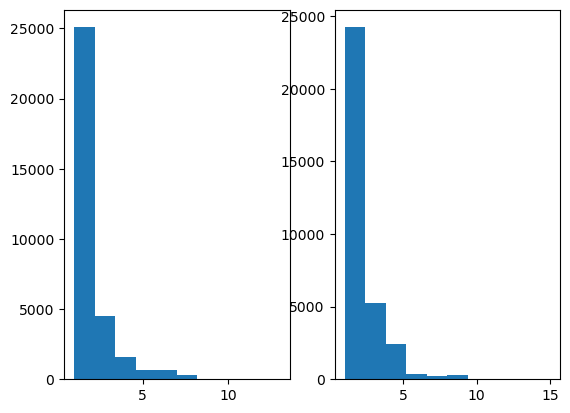

In [11]:
# Plotting number of words distribution
plt.subplot(1, 2, 1)
plt.hist(eng_words_sentences)

plt.subplot(1, 2, 2)
plt.hist(hin_word_sentences)

In [52]:
# Let's cover the maximum number of data
max_len_eng = np.percentile(eng_words_sentences, 0.99)
max_len_hin = np.percentile(hin_word_sentences, 0.99)
max_len_eng, max_len_hin

(1.0, 1.0)

### Create Encoder class

In [21]:
class Encoder(tf.keras.layers.Layer):

    def __init__(self, input_dim, units, **kwargs):
        # initialisation of the variables
        super.__init__(**kwargs)
        self.input_dim = input_dim
        self.units = units

        #initialisation of the layers required
        self.lstm_layer = layers.RNN(layers.LSTMCell(self.units), return_sequences= True)
        

    def call(self, inputs):
        x = layers.Bidirectional(self.lstm_layer)(inputs)
        x = layers.Concatenate([inputs, x])
        for _ in range(2, 8):
            stack_input = x
            stack_output = self.lstm_layer(x)
            x = layers.Concatenate([stack_input, stack_output])

        return x


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(eng_sentences, hin_sentences, test_size= 0.2,
                                                    random_state= 42)
len(X_train), len(X_test), len(y_train), len(y_test)

(26290, 6573, 26290, 6573)

In [53]:
text = 'My name is Krish'
eng_vectorizer = layers.TextVectorization(max_tokens= 30000,
                                          output_sequence_length= int(max_len_eng),
                                          pad_to_max_tokens= True, 
                                          name= 'text_vectorization_layer')

eng_vectorizer.adapt(X_train)



In [59]:
random_text = random.choice(X_train)
print(f"Original text: {random_text}")
print(f"Vectorized text: {eng_vectorizer(random_text)}")

Original text:  Gujarat Samachar
Vectorized text: [821]
